In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [4]:

def comprehensive_outlier_analysis(file_path):
    """
    Comprehensive outlier detection and analysis for customer segmentation data.
    """
    
    # Load data
    df = pd.read_csv(file_path)
    print("="*80)
    print("COMPREHENSIVE OUTLIER DETECTION ANALYSIS")
    print("="*80)
    print(f"Dataset: {len(df)} records, {len(df.columns)} columns")
    
    # 1. STATISTICAL OUTLIERS (IQR Method)
    print("\n🔢 STATISTICAL OUTLIERS (IQR METHOD):")
    print("-" * 50)
    
    numerical_cols = ['Age', 'Work_Experience', 'Family_Size']
    outlier_summary = {}
    
    for col in numerical_cols:
        # Remove null values for analysis
        values = df[col].dropna()
        
        if len(values) == 0:
            continue
            
        # Calculate IQR
        Q1 = values.quantile(0.25)
        Q3 = values.quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Find outliers
        outliers_mask = (values < lower_bound) | (values > upper_bound)
        outlier_values = values[outliers_mask]
        
        # Store results
        outlier_summary[col] = {
            'count': len(outlier_values),
            'percentage': (len(outlier_values) / len(values)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outlier_values': sorted(outlier_values.unique())
        }
        
        print(f"\n{col}:")
        print(f"  Range: {values.min()} - {values.max()}")
        print(f"  Normal range: [{lower_bound:.1f}, {upper_bound:.1f}]")
        print(f"  Outliers: {len(outlier_values)}/{len(values)} ({len(outlier_values)/len(values)*100:.1f}%)")
        
        if len(outlier_values) > 0:
            unique_outliers = sorted(outlier_values.unique())
            if len(unique_outliers) <= 20:
                print(f"  Outlier values: {unique_outliers}")
            else:
                print(f"  Sample outliers: {unique_outliers[:10]} ... ({len(unique_outliers)} unique)")
    
    # 2. CATEGORICAL DISTRIBUTION ANALYSIS
    print("\n\n📊 CATEGORICAL DISTRIBUTION ANALYSIS:")
    print("-" * 50)
    
    categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']
    
    for col in categorical_cols:
        value_counts = df[col].value_counts()
        total_non_null = df[col].count()
        
        print(f"\n{col}:")
        for value, count in value_counts.items():
            percentage = (count / total_non_null) * 100
            status = ""
            if percentage < 1:
                status = " ⚠️ Very rare"
            elif percentage > 90:
                status = " ⚠️ Heavily skewed"
            
            print(f"  {value}: {count} ({percentage:.1f}%){status}")
    
    # 3. SPECIFIC OUTLIER RECORDS
    print("\n\n🎯 SPECIFIC OUTLIER RECORDS:")
    print("-" * 50)
    
    # Age outliers (88-89 years)
    age_outliers = df[df['Age'] >= 88]
    print(f"\n1. AGE OUTLIERS (88+ years): {len(age_outliers)} records")
    if len(age_outliers) > 0:
        for idx, row in age_outliers.head(10).iterrows():
            print(f"   Customer {row['Customer ID']}: Age {row['Age']}, {row['Profession']}, Work_Exp: {row['Work_Experience']}")
    
    # Work Experience outliers (11+ years)
    work_outliers = df[df['Work_Experience'] >= 11]
    print(f"\n2. WORK EXPERIENCE OUTLIERS (11+ years): {len(work_outliers)} records")
    if len(work_outliers) > 0:
        for idx, row in work_outliers.head(10).iterrows():
            print(f"   Customer {row['Customer ID']}: Work_Exp {row['Work_Experience']}, Age {row['Age']}, {row['Profession']}")
    
    # Family Size outliers (8+ members)
    family_outliers = df[df['Family_Size'] >= 8]
    print(f"\n3. FAMILY SIZE OUTLIERS (8+ members): {len(family_outliers)} records")
    if len(family_outliers) > 0:
        for idx, row in family_outliers.head(10).iterrows():
            print(f"   Customer {row['Customer ID']}: Family_Size {row['Family_Size']}, Age {row['Age']}, {row['Profession']}")
    
    # 4. LOGICAL INCONSISTENCIES
    print("\n\n🔍 LOGICAL INCONSISTENCIES:")
    print("-" * 50)
    
    # Work experience > (Age - 16) - assuming people start working at 16
    df_clean = df.dropna(subset=['Age', 'Work_Experience'])
    impossible_work_exp = df_clean[df_clean['Work_Experience'] > (df_clean['Age'] - 16)]
    
    print(f"\n1. IMPOSSIBLE WORK EXPERIENCE (> Age-16): {len(impossible_work_exp)} records")
    if len(impossible_work_exp) > 0:
        for idx, row in impossible_work_exp.head(10).iterrows():
            max_possible = row['Age'] - 16
            print(f"   Customer {row['Customer ID']}: Age {row['Age']}, Work_Exp {row['Work_Experience']} (Max possible: {max_possible})")
    
    # Graduates with 0 work experience and high age (30+)
    unusual_graduates = df[
        (df['Graduated'] == 'Yes') & 
        (df['Work_Experience'] == 0) & 
        (df['Age'] > 30)
    ]
    
    print(f"\n2. UNUSUAL GRADUATES (Age 30+, 0 work experience): {len(unusual_graduates)} records")
    if len(unusual_graduates) > 0:
        for idx, row in unusual_graduates.head(10).iterrows():
            print(f"   Customer {row['Customer ID']}: Age {row['Age']}, {row['Profession']}, Graduated: {row['Graduated']}")
    
    # High work experience with young age
    young_experienced = df[
        (df['Age'] < 25) & 
        (df['Work_Experience'] > 8)
    ].dropna(subset=['Age', 'Work_Experience'])
    
    print(f"\n3. YOUNG BUT HIGHLY EXPERIENCED (Age < 25, Work_Exp > 8): {len(young_experienced)} records")
    if len(young_experienced) > 0:
        for idx, row in young_experienced.head(5).iterrows():
            print(f"   Customer {row['Customer ID']}: Age {row['Age']}, Work_Exp {row['Work_Experience']}, {row['Profession']}")
    
    # 5. MISSING DATA PATTERNS
    print("\n\n📋 MISSING DATA ANALYSIS:")
    print("-" * 50)
    
    missing_data = {}
    for col in df.columns:
        null_count = df[col].isnull().sum()
        if null_count > 0:
            missing_data[col] = {
                'count': null_count,
                'percentage': (null_count / len(df)) * 100
            }
    
    if missing_data:
        print("Columns with missing data:")
        for col, stats in sorted(missing_data.items(), key=lambda x: x[1]['percentage'], reverse=True):
            print(f"  {col}: {stats['count']} missing ({stats['percentage']:.1f}%)")
    else:
        print("✅ No missing data found!")
    
    # 6. DUPLICATE ANALYSIS
    print("\n\n🔄 DUPLICATE ANALYSIS:")
    print("-" * 50)
    
    # Customer ID duplicates
    customer_id_dupes = df[df.duplicated(subset=['Customer ID'], keep=False)]
    unique_duplicate_ids = customer_id_dupes['Customer ID'].nunique()
    
    print(f"Customer ID duplicates: {len(customer_id_dupes)} records ({unique_duplicate_ids} unique IDs)")
    
    # Complete record duplicates
    complete_dupes = df[df.duplicated(keep=False)]
    print(f"Complete record duplicates: {len(complete_dupes)} records")
    
    # 7. FINAL SUMMARY
    print("\n" + "="*80)
    print("📈 COMPREHENSIVE OUTLIER SUMMARY")
    print("="*80)
    
    print("\n🔢 Statistical Outliers (IQR Method):")
    total_statistical_outliers = 0
    for col, stats in outlier_summary.items():
        print(f"  • {col}: {stats['count']} records ({stats['percentage']:.1f}%)")
        total_statistical_outliers += stats['count']
    
    print(f"\n🧩 Logical Inconsistencies:")
    print(f"  • Impossible work experience: {len(impossible_work_exp)} records")
    print(f"  • Unusual graduates (30+ age, 0 exp): {len(unusual_graduates)} records")
    print(f"  • Young but highly experienced: {len(young_experienced)} records")
    
    print(f"\n📊 Data Quality Issues:")
    if missing_data:
        for col, stats in missing_data.items():
            print(f"  • Missing {col}: {stats['count']} records ({stats['percentage']:.1f}%)")
    print(f"  • Customer ID duplicates: {len(customer_id_dupes)} records")
    
    print(f"\n🎯 Overall Assessment:")
    total_problematic = (total_statistical_outliers + len(impossible_work_exp) + 
                        len(unusual_graduates) + len(customer_id_dupes))
    print(f"  • Total problematic records: ~{total_problematic} ({total_problematic/len(df)*100:.1f}%)")
    print(f"  • Data quality: {'Good' if total_problematic/len(df) < 0.05 else 'Needs attention'}")
    
    return {
        'statistical_outliers': outlier_summary,
        'age_outliers': age_outliers,
        'work_outliers': work_outliers,
        'family_outliers': family_outliers,
        'logical_inconsistencies': impossible_work_exp,
        'unusual_graduates': unusual_graduates,
        'missing_data': missing_data,
        'duplicate_records': customer_id_dupes
    }

def create_outlier_visualizations(df, outlier_results):
    """
    Create visualizations for outlier analysis.
    """
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Customer Segmentation: Outlier Analysis Visualizations', fontsize=16, fontweight='bold')
    
    # 1. Age distribution with outliers highlighted
    ax1 = axes[0, 0]
    df['Age'].hist(bins=30, alpha=0.7, ax=ax1, color='skyblue', edgecolor='black')
    outlier_ages = outlier_results['age_outliers']['Age'] if len(outlier_results['age_outliers']) > 0 else []
    if len(outlier_ages) > 0:
        ax1.axvline(x=87.5, color='red', linestyle='--', label='Outlier threshold (87.5)')
        for age in outlier_ages:
            ax1.axvline(x=age, color='red', alpha=0.6)
    ax1.set_title('Age Distribution\n(Red lines = Outliers)')
    ax1.set_xlabel('Age')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    
    # 2. Work Experience distribution
    ax2 = axes[0, 1]
    work_exp_clean = df['Work_Experience'].dropna()
    work_exp_clean.hist(bins=15, alpha=0.7, ax=ax2, color='lightgreen', edgecolor='black')
    ax2.axvline(x=10.5, color='red', linestyle='--', label='Outlier threshold (10.5)')
    ax2.set_title('Work Experience Distribution\n(Red line = Outlier threshold)')
    ax2.set_xlabel('Work Experience (years)')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # 3. Family Size distribution
    ax3 = axes[0, 2]
    family_size_clean = df['Family_Size'].dropna()
    family_size_counts = family_size_clean.value_counts().sort_index()
    family_size_counts.plot(kind='bar', ax=ax3, color='lightcoral', alpha=0.7)
    ax3.axvline(x=6.5, color='red', linestyle='--', label='Outlier threshold (7.5)')
    ax3.set_title('Family Size Distribution\n(Red line = Outlier threshold)')
    ax3.set_xlabel('Family Size')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=0)
    
    # 4. Box plots for numerical variables
    ax4 = axes[1, 0]
    numerical_data = df[['Age', 'Work_Experience', 'Family_Size']].dropna()
    box_data = [numerical_data['Age'], numerical_data['Work_Experience'], numerical_data['Family_Size']]
    box_labels = ['Age', 'Work_Exp', 'Family_Size']
    ax4.boxplot(box_data, labels=box_labels)
    ax4.set_title('Box Plots\n(Outliers shown as points)')
    ax4.set_ylabel('Values')
    
    # 5. Profession distribution
    ax5 = axes[1, 1]
    profession_counts = df['Profession'].value_counts()
    profession_counts.plot(kind='bar', ax=ax5, color='gold', alpha=0.7)
    ax5.set_title('Profession Distribution')
    ax5.set_xlabel('Profession')
    ax5.set_ylabel('Count')
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Missing data heatmap
    ax6 = axes[1, 2]
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    if len(missing_data) > 0:
        missing_data.plot(kind='bar', ax=ax6, color='red', alpha=0.7)
        ax6.set_title('Missing Data by Column')
        ax6.set_xlabel('Columns')
        ax6.set_ylabel('Missing Count')
        ax6.tick_params(axis='x', rotation=45)
    else:
        ax6.text(0.5, 0.5, 'No Missing Data', transform=ax6.transAxes, 
                ha='center', va='center', fontsize=14)
        ax6.set_title('Missing Data Analysis')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage and additional analysis functions
def analyze_outlier_impact(df, outlier_results):
    """
    Analyze the potential impact of outliers on analysis.
    """
    
    print("\n" + "="*60)
    print("OUTLIER IMPACT ANALYSIS")
    print("="*60)
    
    # Calculate statistics with and without outliers
    numerical_cols = ['Age', 'Work_Experience', 'Family_Size']
    
    for col in numerical_cols:
        original_data = df[col].dropna()
        
        # Remove outliers based on IQR
        Q1 = original_data.quantile(0.25)
        Q3 = original_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        clean_data = original_data[(original_data >= lower_bound) & (original_data <= upper_bound)]
        
        print(f"\n{col}:")
        print(f"  With outliers    - Mean: {original_data.mean():.2f}, Std: {original_data.std():.2f}")
        print(f"  Without outliers - Mean: {clean_data.mean():.2f}, Std: {clean_data.std():.2f}")
        print(f"  Impact on mean: {abs(original_data.mean() - clean_data.mean()):.2f}")
        print(f"  Impact on std:  {abs(original_data.std() - clean_data.std()):.2f}")




COMPREHENSIVE OUTLIER DETECTION ANALYSIS
Dataset: 8363 records, 9 columns

🔢 STATISTICAL OUTLIERS (IQR METHOD):
--------------------------------------------------

Age:
  Range: 18 - 89
  Normal range: [-2.0, 86.0]
  Outliers: 129/8363 (1.5%)
  Outlier values: [np.int64(87), np.int64(88), np.int64(89)]

Work_Experience:
  Range: 0.0 - 14.0
  Normal range: [-6.0, 10.0]
  Outliers: 194/7506 (2.6%)
  Outlier values: [np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0)]

Family_Size:
  Range: 1.0 - 9.0
  Normal range: [-1.0, 7.0]
  Outliers: 98/8019 (1.2%)
  Outlier values: [np.float64(8.0), np.float64(9.0)]


📊 CATEGORICAL DISTRIBUTION ANALYSIS:
--------------------------------------------------

Gender:
  Male: 4579 (54.8%)
  Female: 3784 (45.2%)

Ever_Married:
  Yes: 4807 (58.5%)
  No: 3412 (41.5%)

Graduated:
  Yes: 5151 (62.2%)
  No: 3132 (37.8%)

Profession:
  Artist: 2608 (31.7%)
  Healthcare: 1382 (16.8%)
  Entertainment: 987 (12.0%)
  Engineer: 720 (8.7%)
  Doct

/var/folders/8x/4tbqnfzd0tz4gn4chf6rr2ch0000gp/T/ipykernel_12961/3999767349.py:266: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(box_data, labels=box_labels)


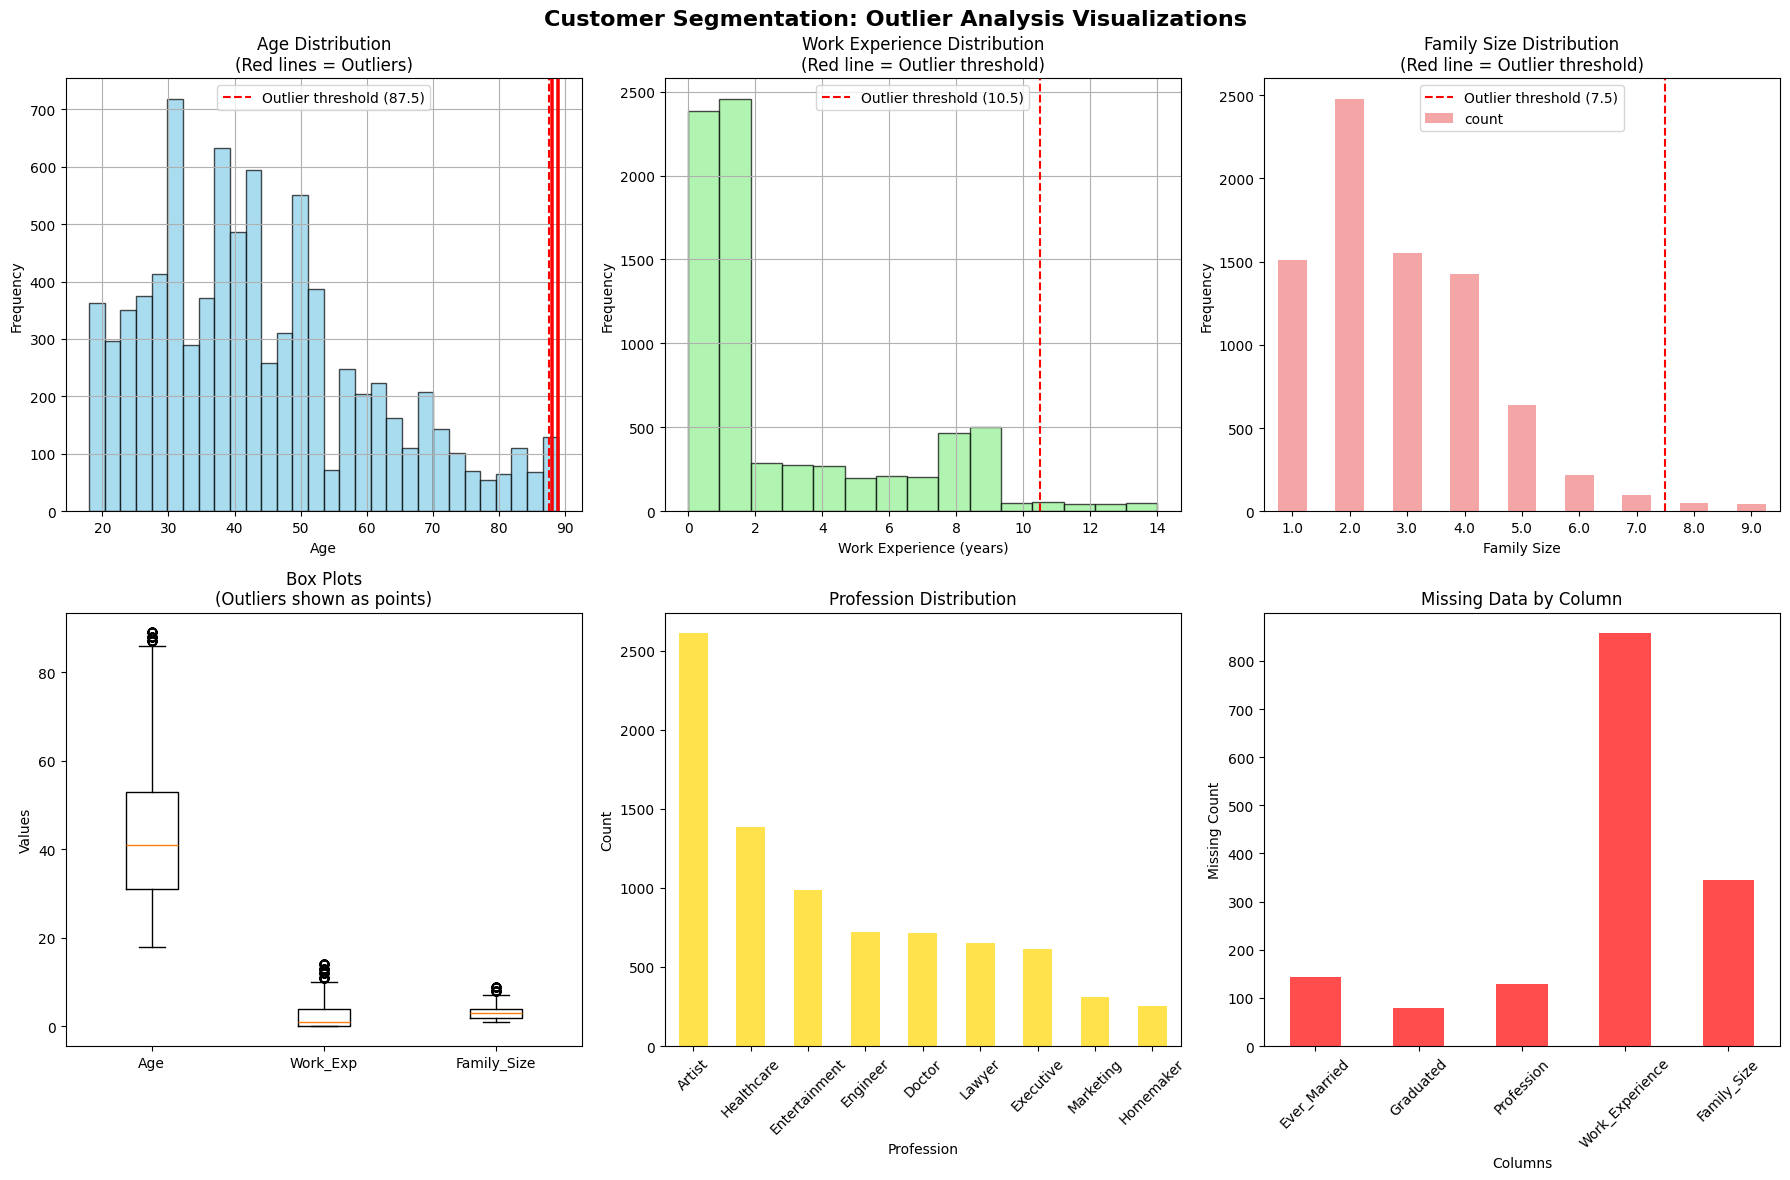


OUTLIER IMPACT ANALYSIS

Age:
  With outliers    - Mean: 43.84, Std: 16.83
  Without outliers - Mean: 43.15, Std: 16.02
  Impact on mean: 0.69
  Impact on std:  0.81

Work_Experience:
  With outliers    - Mean: 2.64, Std: 3.40
  Without outliers - Mean: 2.38, Std: 3.03
  Impact on mean: 0.26
  Impact on std:  0.37

Family_Size:
  With outliers    - Mean: 2.85, Std: 1.53
  Without outliers - Mean: 2.78, Std: 1.41
  Impact on mean: 0.07
  Impact on std:  0.13

✅ Outlier analysis completed!
📊 Results stored in 'outlier_results' dictionary


In [5]:

# Main execution
if __name__ == "__main__":
    # Replace with your file path
    file_path = '../data/Customer Segmentation DeDup.csv'
    
    try:
        # Load data
        df = pd.read_csv(file_path)
        
        # Run comprehensive analysis
        outlier_results = comprehensive_outlier_analysis(file_path)
        
        # Create visualizations
        print("\nCreating visualizations...")
        fig = create_outlier_visualizations(df, outlier_results)
        
        # Analyze impact
        analyze_outlier_impact(df, outlier_results)
        
        # Get recommendations
        # recommend_actions(outlier_results)
        
        print(f"\n✅ Outlier analysis completed!")
        print(f"📊 Results stored in 'outlier_results' dictionary")
        
    except FileNotFoundError:
        print(f"❌ File not found: {file_path}")
        print("Please ensure the CSV file exists in the specified path.")
    except Exception as e:
        print(f"❌ An error occurred: {str(e)}")

## RECOMMENDATIONS FOR OUTLIER HANDLING
1. Statistical Outliers:
    - Age outliers (88-89): - represent legitimate elderly customers
    - Work experience outliers (11-14): - might represent highly experienced professionals
    - Family size outliers (8-9): - might represent large families
    
2. Logical Inconsistencies:
    - Impossible work experience: - likely data entry errors
    - Age < 20 years and Work Exp > 12
    - Assuming work experience field is a categorical variable and not representing number of years or work experience
    
3. Missing Data:
    - Work Experience (10.3% missing): Consider imputation based on age/profession
    - Family Size (4.2% missing): Consider imputation based on demographics
    
4. Duplicate Records:
    - Customer ID duplicates: Apply deduplication rules (higher age/experience)
    - Review data collection process to prevent future duplicates
    